# Donald Trump Tweets Generator

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import tensorflow as tf
import time
import re
import operator
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from operator import itemgetter
import warnings
warnings.filterwarnings('ignore')

### 1. Data Collection

In [2]:
# Import the tweets dataset downloaded from kaggle
data = pd.read_csv("Donald-Tweets!.csv")

### 2. Tweets Inspection

In [3]:
#check the dataset by inspecting the first 5 entries
data.head()

,Date,Time,Tweet_Text,Type,Media_Type,Hashtags,Tweet_Id,Tweet_Url,twt_favourites_IS_THIS_LIKE_QUESTION_MARK,Retweets,Unnamed: 10,Unnamed: 11
0,16-11-11,15:26:37,Today we express our deepest gratitude to all ...,text,photo,ThankAVet,7.970000e+17,https://twitter.com/realDonaldTrump/status/797...,127213,41112,NaN,NaN
1,16-11-11,13:33:35,Busy day planned in New York. Will soon be mak...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/797...,141527,28654,NaN,NaN
2,16-11-11,11:14:20,Love the fact that the small groups of protest...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/797...,183729,50039,NaN,NaN
3,16-11-11,2:19:44,Just had a very open and successful presidenti...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/796...,214001,67010,NaN,NaN
4,16-11-11,2:10:46,A fantastic day in D.C. Met with President Oba...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/796...,178499,36688,NaN,NaN


In [5]:
#check the rows and columns of data
data.shape

(7375, 12)

In [6]:
#Collect tweets from the data
tweets = data.Tweet_Text

In [7]:
# Check the tweets by inspecting some of the tweets
for i in range(10,20):
    print(tweets[i]+"\n")

RT @DonaldJTrumpJr: FINAL PUSH! Eric and I doing dozens of radio interviews. We can win this thing! GET OUT AND VOTE! #MAGA #ElectionDay ht_

Still time to #VoteTrump!
#iVoted #ElectionNight https://t.co/UZtYAY1Ba6

Dont let up, keep getting out to vote - this election is FAR FROM OVER! We are doing well but there is much time left. GO FLORIDA!

Just out according to @CNN: "Utah officials report voting machine problems across entire country"

I will be watching the election results from Trump Tower in Manhattan with my family and friends. Very exciting!

#ElectionDay https://t.co/MXrAxYnTjY https://t.co/FZhOncih21

We need your vote. Go to the POLLS! Lets continue this MOVEMENT! Find your poll location: https://t.co/VMUdvi1tx1_ https://t.co/zGOx74Ebhw

VOTE TODAY! Go to https://t.co/MXrAxYnTjY to find your polling location. We are going to Make America Great Again!_ https://t.co/KPQ5EY9VwQ

TODAY WE MAKE AMERICA GREAT AGAIN!

Today we are going to win the great state of MICHIGAN and we

### 3. Data Curation

In [8]:
#Clean tweets method to make all characters lowercase and remove all the unwanted characters from each tweet
def tweet_preprocessing(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'[_"\-;%()|.,+&=*%]', '', tweet)
    tweet = re.sub(r'\.', ' . ', tweet)
    tweet = re.sub(r'\!', ' !', tweet)
    tweet = re.sub(r'\?', ' ?', tweet)
    tweet = re.sub(r'\,', ' ,', tweet)
    tweet = re.sub(r':', ' : ', tweet)
    tweet = re.sub(r'#', ' # ', tweet)
    tweet = re.sub(r'@', ' @ ', tweet)
    tweet = re.sub(r'd .c .', 'd.c.', tweet)
    tweet = re.sub(r'u .s .', 'd.c.', tweet)
    tweet = re.sub(r' amp ', ' and ', tweet)
    tweet = re.sub(r'pm', ' pm ', tweet)
    tweet = re.sub(r'news', ' news ', tweet)
    tweet = re.sub(r' . . . ', ' ', tweet)
    tweet = re.sub(r' .  .  . ', ' ', tweet)
    tweet = re.sub(r' ! ! ', ' ! ', tweet)
    tweet = re.sub(r'&amp', 'and', tweet)
    return tweet

In [9]:
# Call clean tweets function with the tweets dataset from above and prepare list of cleaned tweets
cleaned_tweets = []
for tweet in tweets:
    tweet = tweet_preprocessing(tweet)
    if len(tweet) > 0:
        cleaned_tweets.append(tweet)


In [10]:
# Check to ensure the tweets have been clean properly
for i in range(20,30):
    print(cleaned_tweets[i]+"\n")  

rt  @ erictrump :  sean hannity :  if hillary wins you own it 

rt  @ donaldjtrumpjr :  thanks new hampshire ! !
 # nh  # newhampshire  # maga 

rt  @ detroit news  ivankatrump in michigan :  this is your movement۪ 

unbelievable evening in new hampshire  thank you ! flying to grand rapids michigan now
watch nh rally here :  

big  news  to share in new hampshire tonight ! polls looking great ! see you soon

today in florida i pledged to stand with the people of cuba and venezuela in their fight against oppression cont :  

thank you pennsylvania ! going to new hampshire now and on to michigan watch pa rally here :  

live on  # periscope :  join me for a few minutes in pennsylvania get out and vote tomorrow lets  # maga ! 

hey missouri lets defeat crooked hillary and  @ koster4missouri ! koster supports obamacare and amnesty ! vote outsider navy seal  @ ericgreitens !

america must decide between failed policies or fresh perspective a corrupt system or an outsider




### 4. Word-Vector Generation:

In [11]:
# Count the occurences of each word, and create a map word_counts
word_map = {}
for tweet in cleaned_tweets:
    for word in tweet.split():
        if word not in word_map:
            word_map[word] = 1
        else:
            word_map[word] += 1
print("Number of different words used :", len(word_map.keys()))

Number of different words used : 11612


In [12]:
# Load curated data from GloVe's embeddings
embeddings_index = {}
with open('glove.twitter.27B.200d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

Word embeddings: 1193515


In [13]:
# Using embedding index, create an 'average' embedding for each tweet

#Match the glo-ve dimensions with 200
embedding_dim = 200 

# Contains the 'average' embedding for each tweet
embed_tweets = [] 
total_embeds = 0 
null_embeds = 0 

for tweet in cleaned_tweets:
    # Set default embedding as zero for each tweet
    avg_embed = np.zeros(embedding_dim) 
    for word in tweet.split():
        total_embeds += 1
        embed = embeddings_index.get(word)
        if embed is not None:
            # Add embedding's values to vectors
            avg_embed += embed 
        else:
            null_embeds += 1
    embed_tweets.append(avg_embed/len(tweet.split()))

print("Number of Embeddings:", total_embeds)
print("Number of Null Embeddings:", null_embeds)
print("% of Null Embeddings: {}%".format(round(null_embeds/total_embeds,4)*100))

Number of Embeddings: 138153
Number of Null Embeddings: 12386
% of Null Embeddings: 8.97%


### 5.	Dimensionality Reduction: 

In [14]:
# Reduce the dimensions of tweet from 200 to 1
pca = PCA(n_components=1, random_state = 2)
pca_tweets = pca.fit_transform(embed_tweets)

In [15]:
# Arranging tweets in ascending order based on their PCA values such that similar ones lie closer
pca_tweets_list = []
for tweet in pca_tweets:
    pca_tweets_list.append(tweet[0])

order = np.array(pca_tweets_list).argsort()
pca_labels = order.argsort()
# Odd valued label => Used for generating tweets
# Even valued label => training tweets
pca_labels *= 2 

In [16]:
# Inspect pca_labels, finding all are even
pca_labels[:5]

array([4540,  464,  206, 4652, 5004], dtype=int64)

### 6.	K-Means Clustering:

In [17]:
# Grouping tweets into 4 clusters
kmeans = KMeans(n_clusters=4, max_iter = 1000, n_init = 20, random_state=2).fit(pca_tweets)
labels = kmeans.labels_

In [18]:
# Inspect count of tweets in each group.
pd.DataFrame(labels)[0].value_counts()

3    2782
1    2600
2    1674
0     315
Name: 0, dtype: int64

### 7. Identifying stop, common and top words

In [19]:
# Words to not include when finding the most common words in each group
stop_words = ['be','on','!','at','.',':','...','@',',','#','will','.m','in','a','the','with','to','by','and','my','is',
              'of','for','new','via','are','that','has','have','all','as','it','so','they','do','he','just','this',
              'was','who','your','from','his','about','get','but','am','up','if','can','would','than','should','dont',
              'had','or','were','did','there','got','even','its','an']

In [20]:
#Find the n most common words in each group
def top_n_words(group, n_words):
    # Create the map for each group
    vocab = {} 
    for i in range(len(cleaned_tweets)):
        if labels[i] == group:
            for word in cleaned_tweets[i].split():
                if word not in vocab:
                    vocab[word] = 1
                else:
                    vocab[word] += 1
      
    # Sort the map from most to least common words i.e. descending order
    sorted_vocab = sorted(vocab.items(), key=operator.itemgetter(1), reverse=True)
    top_n_words = []
    for word, value in sorted_vocab:
        if word not in stop_words:
            top_n_words.append(word)
        if len(top_n_words) == n_words:
            break
    print(top_n_words)

In [21]:
# Printing top 10 words in each group 
groups = len(np.unique(labels))
for i in range(groups):
    print("Group #",i+1)
    top_n_words(i, 10)

Group # 1
['trump2016', 'makeamericagreatagain', 'realdonaldtrump', 'trump', 'rt', 'poll', 'danscavino', 'news', 'gop', 'you']
Group # 2
['realdonaldtrump', 'you', 'trump', 'i', 'great', 'thank', 'we', 'news', 'america', 'rt']
Group # 3
['realdonaldtrump', 'trump', 'you', 'trump2016', 'thank', 'makeamericagreatagain', 'rt', 'news', 'poll', 'donald']
Group # 4
['i', 'you', 'great', 'we', 'not', 'me', 'people', 'hillary', 'thank', 'our']


In [22]:
# Generalizing thw most common words from all of Trump's tweets
n_words = 100
sorted_vocab = sorted(word_map.items(), key=operator.itemgetter(1), reverse=True)
top_n_words = []
for word, value in sorted_vocab:
    if word not in stop_words:
        top_n_words.append(word)
    if len(top_n_words) == n_words:
        break
print("Trump's {} most popular tweeted words (excluding stop words):".format(n_words))
print(top_n_words)

Trump's 100 most popular tweeted words (excluding stop words):
['you', 'i', 'realdonaldtrump', 'trump', 'great', 'thank', 'we', 'trump2016', 'me', 'hillary', 'news', 'not', 'makeamericagreatagain', 'america', 'rt', 'people', 'our', '?', 'fox', 'out', 'poll', 'make', 'no', 'again', 'donald', 'very', 'clinton', 'cnn', 'now', 'pm', 'like', 'president', 'more', 'big', 'vote', 'debate', 'tonight', 'she', 'what', 'time', 'us', 'one', 'cruz', 'her', 'crooked', 'going', 'only', 'country', 'last', 'back', 'today', 'why', 'join', 'said', 'many', 'never', 'iowa', 'him', 'good', 'been', 'much', 'how', 'watch', 'win', 'when', 'night', 'love', 'want', 'media', 'enjoy', 'polls', 'bad', 'gop', 'support', 'tomorrow', 'go', 'job', 'see', 'campaign', 'interviewed', 'rubio', 'jeb', 'crowd', 'amazing', 'ted', 'their', 'cant', 'nice', 'need', 'really', 'them', 'thanks', 'wow', 'show', '00', 'obama', '7', 'over', 'speech', 'way']


### 8. Data Visualization

#### Printing Tweets group-wise

In [23]:
#Method to print first n tweets from a group
def print_tweet_group(group, n_tweets):
    count = 1
    for i in range(len(cleaned_tweets)):
        if labels[i] == group:
            print("#{}: {}".format(count, cleaned_tweets[i]))
            count += 1
            if count == n_tweets+1:
                break

In [24]:
# Calling function to print the first 5 tweets in each group
n_tweets = 5
for i in range(groups):
    print("Group #",i+1)
    print_tweet_group(i,n_tweets)
    print()

Group # 1
#1:  # electionday 
#2: rt  @ donaldjtrumpjr :  thanks new hampshire ! !
 # nh  # newhampshire  # maga 
#3:  # draintheswamp !

#4:  # makeamericagreatagain  # 6days 
#5:  @ pynance :  evangelical women live at  # trumptower  @ pdpryor1  @ cissieglynch  @ saysgabrielle 

Group # 2
#1: rt  @ ivankatrump :  such a surreal moment to vote for my father for president of the united states ! make your voice heard and vote !  # election2
#2: rt  @ erictrump :  join my family in this incredible movement to  # makeamericagreatagain ! now it is up to you ! please  # vote for america ! https : 
#3: rt  @ donaldjtrumpjr :  final push ! eric and i doing dozens of radio interviews we can win this thing ! get out and vote !  # maga  # electionday ht
#4: just out according to  @ cnn :  utah officials report voting machine problems across entire country
#5: rt  @ erictrump :  sean hannity :  if hillary wins you own it 

Group # 3
#1: watching the returns at 9 : 45 pm 
 # electionnight  # maga 

We can clearly see that the tweets are categorized as,
1. Short tweets containing many # or @
2. Retweets possessing long texts
3. Relating containing datae,time or location
4. Longer tweets

In [25]:
# Visualize the tweets with t-distributed stochastic neighbor embedding(TSNE)
model = TSNE(n_components=2, random_state=2)
TSNE_tweets = model.fit_transform(embed_tweets)

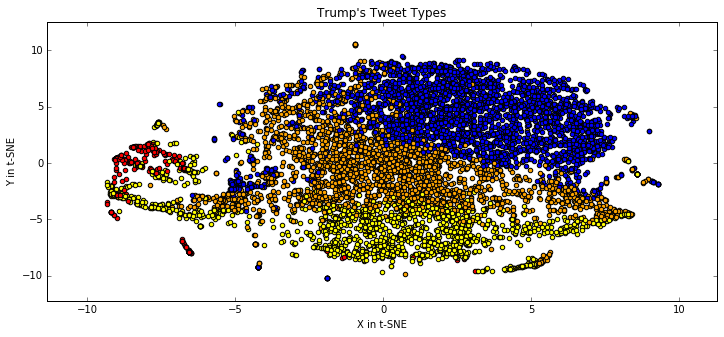

In [25]:
# Build a scatter plot to visualize the t-SNE tweets.
color_map = {0:'red', 1:'orange', 2:'yellow', 3:'blue'}
plt.figure(figsize=(12,5))

for i in range(len(TSNE_tweets)):
    plt.scatter(x = TSNE_tweets[i][0], 
                y = TSNE_tweets[i][1],
                c = color_map[labels[i]])
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.title('Trump\'s Tweet Types')

offset = 2
x_min = min(TSNE_tweets, key=itemgetter(0))[0] - offset
x_max = max(TSNE_tweets, key=itemgetter(0))[0] + offset
y_min = min(TSNE_tweets, key=itemgetter(1))[1] - offset
y_max = max(TSNE_tweets, key=itemgetter(1))[1] + offset

axes = plt.gca()
axes.set_xlim([x_min,x_max])
axes.set_ylim([y_min,y_max])
plt.show()

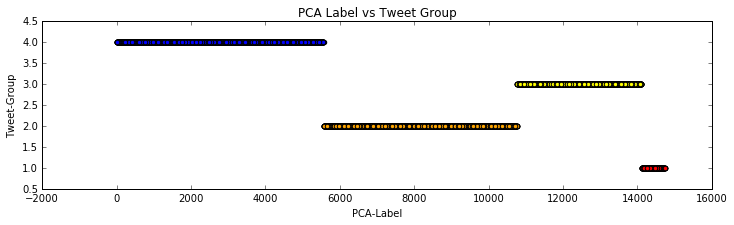

In [26]:
# Scatterplot to visualize the tweet groups by their PCA labels
color_map = {0:'red', 1:'orange', 2:'yellow', 3:'blue'}
plt.figure(figsize=(12,3))
for i in range(len(TSNE_tweets)):
    plt.scatter(x = pca_labels[i], 
                y = labels[i]+1,
                c = color_map[labels[i]])
    
plt.xlabel('PCA-Label')
plt.ylabel('Tweet-Group')
plt.title('PCA Label vs Tweet Group')
    
plt.show()

### 8. Preparing Training Data

In [27]:
# Limiting the words used which appeared ≥ threshold 

#dictionary to convert words to integers
vocab_to_int = {} 

#Setting the limit of count to 10
threshold = 10

value = 0
for word, count in word_map.items():
    if count >= threshold:
        vocab_to_int[word] = value
        value += 1

# Special tokens that will be added to our vocab
codes = ["<UNK>","<GO>","<PAD>","<EOS>"]   

for code in codes:
    vocab_to_int[code] = len(vocab_to_int)+1

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

word_ratio = round(len(vocab_to_int) / len(word_map),4)*100

print("Number of Unique Words:", len(word_map))
print("Number of Words above Threshold:", len(vocab_to_int))
print("Percent of Words above Threshold: {}%".format(word_ratio))

Number of Unique Words: 11612
Number of Words above Threshold: 1375
Percent of Words above Threshold: 11.84%


In [28]:
# Convert the tweets from words to integers
# If word is not in vocabulary, replace it with <UNK> (unknown) tag
int_tweets = []

for tweet in cleaned_tweets:
    int_tweet = []
    for word in tweet.split():
        if word in vocab_to_int:
            int_tweet.append(vocab_to_int[word])
        else:
            int_tweet.append(vocab_to_int["<UNK>"])
    int_tweets.append(int_tweet)

In [29]:
# Find the length of tweets
lengths = []
for tweet in int_tweets:
    lengths.append(len(tweet))

# Create a dataframe to inspect the lengths
lengths = pd.DataFrame(lengths, columns=['counts'])

In [30]:
lengths.describe()

,counts
count,7371.000000
mean,18.742776
std,6.713868
min,1.000000
25%,14.000000
50%,20.000000
75%,24.000000
max,35.000000


In [31]:
#Considering the tweets that are between the min and max lengths (1 and 25) and ≤ the <UNK> limit

max_tweet_length = 25
min_tweet_length = 1
unk_limit = 1

short_tweets = []
short_labels = []

for i in range(len(int_tweets)):
    unk_count = 0
    if len(int_tweets[i]) <= max_tweet_length and len(int_tweets[i]) >= min_tweet_length:
        if len(int_tweets[i]) == 1:
            if int_tweets[i][0] != vocab_to_int['<UNK>']:
                short_tweets.append(int_tweets[i])
                short_labels.append(pca_labels[i])
        else:
            for word in int_tweets[i]:
                if word == vocab_to_int['<UNK>']:
                    unk_count += 1
            if unk_count <= unk_limit:
                short_tweets.append(int_tweets[i])
                short_labels.append(pca_labels[i])
        

usage_precent = round(len(short_tweets)/len(cleaned_tweets),4)*100
        
print("Number of Tweets in total:", len(cleaned_tweets))
print("Number of Tweets used in training:", len(short_tweets))
print("Percentage of Tweets used: {}%".format(usage_precent))

Number of Tweets in total: 7371
Number of Tweets used in training: 2205
Percentage of Tweets used: 29.909999999999997%


In [32]:
# Sorting tweets by their lengths to improve the training rate and reduce padding.
sorted_tweets = []
sorted_labels = []

for length in range(1,max_tweet_length+1):
    for i in range(len(short_tweets)):
        if length == len(short_tweets[i]):
            sorted_tweets.append(short_tweets[i])
            sorted_labels.append([short_labels[i]])
            
print(len(sorted_tweets))
print(len(sorted_labels))

2205
2205


In [33]:
# Calculate the number/ratio of words that are <UNK>
n_words = 0
unk_words = 0
for tweet in sorted_tweets:
    for int in tweet:
        n_words += 1
        if int == vocab_to_int["<UNK>"]:
            unk_words += 1
            
unk_ratio = round(unk_words/n_words,4)*100
            
print("Total Number of Words:", n_words)
print("Number of uses of <UNK>:", unk_words)
print("Percent of words that are <UNK>: {}%".format(unk_ratio))

Total Number of Words: 29533
Number of uses of <UNK>: 1246
Percent of words that are <UNK>: 4.22%


### 9. Build and Train the Model

In [56]:
# inputs placeholder
def model_inputs():
    input_data = tf.placeholder(tf.int32, [None, None], name='input')
    targets = tf.placeholder(tf.int32, [None, None], name='targets')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    return input_data, targets, lr, keep_prob

In [57]:
# Removing the last id, concat the <GO> at begin of each batch
def process_encoding_input(target_data, vocab_to_int, batch_size):
    ending = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    dec_input = tf.concat([tf.fill([batch_size, 1], vocab_to_int['<GO>']), ending], 1)

    return dec_input

In [58]:
# create encoding layer
def encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob, sequence_length):
    lstm = tf.contrib.rnn.BasicLSTMCell(rnn_size)
    enc_cell = tf.contrib.rnn.MultiRNNCell([lstm] * num_layers)
    _, enc_state = tf.nn.dynamic_rnn(enc_cell,
                                     rnn_inputs, 
                                     sequence_length,
                                     dtype=tf.float32)
    return enc_state

In [60]:
# Decoding training data
def decoding_layer_train(encoder_state, dec_cell, dec_embed_input, sequence_length, decoding_scope,
                         output_fn, keep_prob, batch_size):
    train_decoder_fn = tf.contrib.seq2seq.simple_decoder_fn_train(encoder_state)
    train_pred, _, _ = tf.contrib.seq2seq.dynamic_rnn_decoder(
        dec_cell, train_decoder_fn, dec_embed_input, sequence_length, scope=decoding_scope)
    train_pred_drop = tf.nn.dropout(train_pred, keep_prob)
    return output_fn(train_pred_drop)

In [61]:
# Decoding predictions
def decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id, end_of_sequence_id,
                         maximum_length, vocab_size, decoding_scope, output_fn):
    infer_decoder_fn = tf.contrib.seq2seq.simple_decoder_fn_inference(
        output_fn, encoder_state, dec_embeddings, start_of_sequence_id, end_of_sequence_id, maximum_length, vocab_size)
    infer_logits, _, _ = tf.contrib.seq2seq.dynamic_rnn_decoder(
        dec_cell, infer_decoder_fn, scope=decoding_scope)
    return infer_logits

In [62]:
# Create the decoding layer
def decoding_layer(dec_embed_input, dec_embeddings, encoder_state, vocab_size, sequence_length, rnn_size,
                   num_layers, vocab_to_int, keep_prob, batch_size):
    with tf.variable_scope("decoding") as decoding_scope:
        lstm = tf.contrib.rnn.BasicLSTMCell(rnn_size)
        drop = tf.contrib.rnn.DropoutWrapper(lstm, input_keep_prob = keep_prob)
        dec_cell = tf.contrib.rnn.MultiRNNCell([drop] * num_layers)
        
        weights = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1)
        biases = tf.zeros_initializer()
        output_fn = lambda x: tf.contrib.layers.fully_connected(x, 
                                                                vocab_size, 
                                                                None, 
                                                                scope=decoding_scope,
                                                                weights_initializer = weights,
                                                                biases_initializer = biases)

        train_logits = decoding_layer_train(encoder_state, 
                                            dec_cell, 
                                            dec_embed_input, 
                                            sequence_length, 
                                            decoding_scope, 
                                            output_fn, 
                                            keep_prob, 
                                            batch_size)
        decoding_scope.reuse_variables()
        infer_logits = decoding_layer_infer(encoder_state, 
                                            dec_cell, 
                                            dec_embeddings, 
                                            vocab_to_int['<GO>'],
                                            vocab_to_int['<EOS>'], 
                                            sequence_length - 1, 
                                            vocab_size,
                                            decoding_scope, 
                                            output_fn)

    return train_logits, infer_logits

In [63]:
# create the training and inference logits
def one2seq_model(input_data, target_data, keep_prob, batch_size, sequence_length, vocab_size, 
                  embedding_size, rnn_size, num_layers, vocab_to_int):
    enc_embed_input = tf.contrib.layers.embed_sequence(input_data, 
                                                       max(short_labels)+1, 
                                                       embedding_size,
                                                       initializer = tf.random_uniform_initializer(-1,1))
    enc_state = encoding_layer(enc_embed_input, rnn_size, num_layers, keep_prob, sequence_length)

    dec_input = process_encoding_input(target_data, vocab_to_int, batch_size)
    dec_embeddings = tf.Variable(tf.random_uniform([vocab_size+1, embedding_size], -1, 1))

    dec_embed_input = tf.nn.embedding_lookup(dec_embeddings, 
                                             dec_input)
    
    train_logits, infer_logits = decoding_layer(dec_embed_input, 
                                                dec_embeddings, 
                                                enc_state, 
                                                vocab_size, 
                                                sequence_length, 
                                                rnn_size, 
                                                num_layers, 
                                                vocab_to_int, 
                                                keep_prob, 
                                                batch_size)
    return train_logits, infer_logits

In [64]:
# Padding tweets with <PAD> making each tweet to equal length
def pad_tweets_batch(tweets_batch):
    max_tweet = max([len(tweet) for tweet in tweets_batch])
    return [tweet + [vocab_to_int['<PAD>']] * (max_tweet - len(tweet)) for tweet in tweets_batch]

In [65]:
# labels and tweets joined together
def  get_batches(labels, tweets, batch_size):
    for batch_i in range(0, len(labels)//batch_size):
        start_i = batch_i * batch_size
        labels_batch = np.array(labels[start_i:start_i + batch_size])
        tweets_batch = tweets[start_i:start_i + batch_size]
        padded_tweets_batch = np.array(pad_tweets_batch(tweets_batch))
        yield labels_batch, padded_tweets_batch

In [66]:
# Hyperparameters for training such that training is effective
epochs = 100
batch_size = 32
rnn_size = 512
num_layers = 2
embedding_size = 200
learning_rate = 0.005
keep_probability = 0.5

In [67]:
# graph construction
train_graph = tf.Graph()
# default graph to make sure it is ready for training
with train_graph.as_default():
    
    # model inputs    
    input_data, targets, lr, keep_prob = model_inputs()
    # maximum tweet length for each batch
    sequence_length = tf.placeholder_with_default(max_tweet_length, None, name='sequence_length')
    # shape of the input data for sequence_loss
    input_shape = tf.shape(input_data)
    # Creating training and inference logits
    train_logits, inference_logits = one2seq_model(input_data, 
                                                   targets, 
                                                   keep_prob, 
                                                   batch_size, 
                                                   sequence_length, 
                                                   len(vocab_to_int), 
                                                   embedding_size, 
                                                   rnn_size, 
                                                   num_layers, 
                                                   vocab_to_int)

    # Create a tensor 
    tf.identity(inference_logits, 'logits')

    with tf.name_scope("optimization"):
        # defining the loss function
        cost = tf.contrib.seq2seq.sequence_loss(
            train_logits,
            targets,
            tf.ones([input_shape[0], sequence_length]))

        # Optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)

1234234234


In [69]:
# Model training
learning_rate_decay = 0.9
min_learning_rate = 0.0005
# batch count
display_step = 20 
stop_early = 0 
# number of consecutive epochs to consider for stopping criteria
stop = 3 
epoch_check = ((len(sorted_labels))//batch_size)-1 # Modulus for checking epoch loss
epoch_loss = 0 
batch_loss = 0
# recording epoch loss
summary_epoch_loss = [] 

checkpoint = "./best_model.ckpt" 

with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch_i in range(1, epochs+1):
        epoch_loss = 0
        batch_loss = 0
        
        for batch_i, (labels_batch, tweets_batch) in enumerate(
                get_batches(sorted_labels, sorted_tweets, batch_size)):
            start_time = time.time()
            _, loss = sess.run(
                [train_op, cost],
                {input_data: labels_batch,
                 targets: tweets_batch,
                 lr: learning_rate,
                 sequence_length: tweets_batch.shape[1],
                 keep_prob: keep_probability})

            batch_loss += loss
            epoch_loss += loss
            end_time = time.time()
            batch_time = end_time - start_time

            if batch_i % display_step == 0 and batch_i > 0:
                print('Epoch {:>3}/{} Batch {:>4}/{} - Loss: {:>6.3f}, Seconds: {:>4.2f}'
                      .format(epoch_i,
                              epochs, 
                              batch_i, 
                              len(sorted_labels) // batch_size, 
                              batch_loss / display_step, 
                              batch_time*display_step))
                batch_loss = 0

            if batch_i % epoch_check == 0 and batch_i > 0:
                print("Average loss for this epoch:", round(epoch_loss/epoch_check,3))
                summary_epoch_loss.append(epoch_loss)
                
                # If the current epoch loss is at a new minimum, save the model and show it as new record
                if epoch_loss <= min(summary_epoch_loss):
                    print('New Record!') 
                    stop_early = 0
                    saver = tf.train.Saver() 
                    saver.save(sess, checkpoint)

                else:
                    print("No Improvement.")
                    stop_early += 1
                    if stop_early == stop:
                        break
                    
        # adjust learning rate, making sure it is not below its minimum value
        learning_rate *= learning_rate_decay
        if learning_rate < min_learning_rate:
            learning_rate = min_learning_rate
        
        if stop_early == stop:
            print("Stopping Training.")
            break

Epoch   1/100 Batch   20/68 - Loss:  5.557, Seconds: 10.13
Epoch   1/100 Batch   40/68 - Loss:  5.010, Seconds: 16.14
Epoch   1/100 Batch   60/68 - Loss:  5.242, Seconds: 29.52
Average loss for this epoch: 5.309
New Record!
Epoch   2/100 Batch   20/68 - Loss:  3.880, Seconds: 9.06
Epoch   2/100 Batch   40/68 - Loss:  4.234, Seconds: 13.54
Epoch   2/100 Batch   60/68 - Loss:  4.658, Seconds: 22.05
Average loss for this epoch: 4.362
New Record!
Epoch   3/100 Batch   20/68 - Loss:  3.397, Seconds: 9.06
Epoch   3/100 Batch   40/68 - Loss:  3.819, Seconds: 13.61
Epoch   3/100 Batch   60/68 - Loss:  4.469, Seconds: 21.51
Average loss for this epoch: 4.019
New Record!
Epoch   4/100 Batch   20/68 - Loss:  3.218, Seconds: 10.90
Epoch   4/100 Batch   40/68 - Loss:  3.596, Seconds: 16.43
Epoch   4/100 Batch   60/68 - Loss:  4.178, Seconds: 26.62
Average loss for this epoch: 3.786
New Record!
Epoch   5/100 Batch   20/68 - Loss:  2.850, Seconds: 11.08
Epoch   5/100 Batch   40/68 - Loss:  3.361, Sec

### 10. New Tweets Generation (Content Generation): 

In [70]:
#just like training daa
def vectorize_tweet(tweet):
    '''Just like for the training data, this creates the average embedding for the inputted tweet'''
    vect_tweet = []
    vectors = np.zeros(embedding_dim)
    for word in tweet.split():
        vector = embeddings_index.get(word)
        if vector is not None:
            vectors += vector
    return vectors/len(tweet.split())

In [74]:
# give text to match closest tweet from data set
create_tweet = "I need your help to make america great again! #maga"

create_tweet = tweet_preprocessing(create_tweet)

create_tweet_vect = vectorize_tweet(create_tweet)

create_tweet_pca = pca.transform(create_tweet_vect)

# matching the tweet to find similar pca label
similar_tweet = min(pca_tweets_list, key=lambda x:abs(x-create_tweet_pca))

for tweet in enumerate(pca_tweets_list):
    if tweet[1] == similar_tweet:
        # show label of tweet closest to provided tweet .
        print(pca_labels[tweet[0]])
        break

3464


In [75]:
# using the value generated in the previous step
tweet_type = 3464

closest_type = min(short_labels, key=lambda x:abs(x-tweet_type))
words = []
for tweet in enumerate(short_labels):
    if tweet[1] == closest_type:
        for num in short_tweets[tweet[0]]:
            words.append(int_to_vocab[num])
print(" ".join(words))
print()
print("Does tweet type exist in training data:", tweet_type in short_labels)

hillary is the most corrupt person to ever run for the presidency of the united states # draintheswamp

Tweet type in training data: False


In [76]:
# providing the range of tweet types, provide a choice of any random integer in this range for best results
print(min(short_labels), ",", max(short_labels))

0 , 14736


In [86]:
# give your choice for the tweet type
tweet_type = 13799

checkpoint = "./" + checkpoint

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(checkpoint + '.meta')
    loader.restore(sess, checkpoint)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('logits:0')
    sequence_length = loaded_graph.get_tensor_by_name('sequence_length:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')

    tweet_logits = sess.run(logits, {input_data: [[tweet_type]], 
                                     sequence_length: np.random.randint(3,15),
                                     keep_prob: 1.0})[0] 

# Remove the padding from the tweet
pad = vocab_to_int["<PAD>"]

print('  Word Ids:      {}'.format([i for i in np.argmax(tweet_logits, 1) if i != pad]))
print('  Tweet: {}'.format(" ".join([int_to_vocab[i] for i in np.argmax(tweet_logits, 1) if i != pad])))

  Word Ids:[813, 905, 309, 367, 102, 739, 851, 312, 117, 856, 1228]
  Tweet: i will be interviewed by @ oreillyfactor tonight at 8 pm


### Few more generated tweets:

1. thank you arizona ! # makeamericagreatagain # trump2016


2. hillary must be stopped # crookedhillary


3. remember to come out and vote ! # maga # trump2016


4. makeamericagreatagain # 6days


5. rt @ donaldjtrumpjr : final push ! eric and i doing dozens of radio interviews we can win this thing ! get out and vote ! # maga # electionday


6. watching the returns at 9 : 45 pm # electionnight # maga


7.  busy day planned in new york will soon be making some very important decisions on the people who will be running our government !